## Notebook to demonstrate binned unfolding using the boosted decision tree OmniFold
We will use six jet substructure observables based on the Z+jets dataset. We will use the Pythia data samples as the gen/particle-level and reconstructed Monte Carlo data. We will use the reconstructed Herwig samples as the pseudodata. The goal is to do unfolding with the Pythia and Herwig pseudodata to obtain the truth level Herwig samples.

In this notebook, we will do binned unfolding with a response matrix and histograms. We will use ROOT objects (namely RooUnfoldResponse, TH1, and TH2) initially before converting to NumPy arrays during the OmniFold procedure.

In [1]:
import energyflow as ef
import numpy as np
from helpers import get_substructure_obs
from omnifold import binned_omnifold, TH1_to_numpy
import matplotlib.pyplot as plt
import ROOT

### Loading the data
Note the datasets each contain about 1.6 million samples. I have the number of samples set to 100k as a fast example.

In [2]:
num_total_data = 100000

In [3]:
dataset_pythia = ef.zjets_delphes.load('Pythia26', num_data=num_total_data, pad=True, cache_dir="./zjets_dataset",
                                               source='zenodo', which='all',
                                               include_keys=None, exclude_keys=None)
print("Loaded Pythia dataset.")
dataset_herwig = ef.zjets_delphes.load('Herwig', num_data=num_total_data, pad=True, cache_dir="./zjets_dataset",
                                               source='zenodo', which='all',
                                               include_keys=None, exclude_keys=None)
print("Loaded Herwig dataset.")

Loaded Pythia dataset.
Loaded Herwig dataset.


### Setting up all the histograms, response matrices, binning, and labels we'll need

In [4]:
# Note that observable_indices will be the index corresponding to the observable in the dataset for the next cell
observable_names = ["Mass", "Width", "Multiplicity", "SDMass", "zg", "Tau21"]
observable_indices, observable_binning, observable_pseudodata_hists, observable_responses, observable_labels = {}, {}, {}, {}, {}

for observable in observable_names:
    if observable == "Mass":
        observable_indices[observable] = 0
        observable_binning[observable] = (50, 0, 75)
        observable_pseudodata_hists[observable] = ROOT.TH1D("measured_mass_hist", "measured_mass_hist", 50, 0, 75)
        observable_responses[observable] = ROOT.RooUnfoldResponse(50, 0, 75)
        observable_labels[observable] = "Jet Mass $m$ [GeV]"
    elif observable == "Width":
        observable_indices[observable] = 1
        observable_binning[observable] = (50, 0, 0.6)
        observable_pseudodata_hists[observable] = ROOT.TH1D("measured_width_hist", "measured_width_hist", 50, 0, 0.6)
        observable_responses[observable] = ROOT.RooUnfoldResponse(50, 0, 0.6)
        observable_labels[observable] = "Jet Width $W$"
    elif observable == "Multiplicity":
        observable_indices[observable] = 2
        observable_binning[observable] = (80, 0, 80)
        observable_pseudodata_hists[observable] = ROOT.TH1D("measured_mult_hist", "measured_mult_hist", 80, 0, 80)
        observable_responses[observable] = ROOT.RooUnfoldResponse(80, 0, 80)
        observable_labels[observable] = "Jet Constituent Multiplicity $M$ [GeV]"
    elif observable == "SDMass":
        observable_indices[observable] = 3
        observable_binning[observable] = (50, -14, -2)
        observable_pseudodata_hists[observable] = ROOT.TH1D("measured_sdmass_hist", "measured_sdmass_hist", 50, -14, -2)
        observable_responses[observable] = ROOT.RooUnfoldResponse(50, -14, -2)
        observable_labels[observable] = "Soft Drop Jet Mass $ln \\rho$ "
    elif observable == "zg":
        observable_indices[observable] = 4
        observable_binning[observable] = (50, 0, 0.5)
        observable_pseudodata_hists[observable] = ROOT.TH1D("measured_zg_hist", "measured_zg_hist", 50, 0, 0.5)
        observable_responses[observable] = ROOT.RooUnfoldResponse(50, 0, 0.5)
        observable_labels[observable] = "Groomed Jet Momentum Fraction $z_{g}$"
    elif observable == "Tau21":
        observable_indices[observable] = 5
        observable_binning[observable] = (50, 0, 1.2)
        observable_pseudodata_hists[observable] = ROOT.TH1D("measured_tau21_hist", "measured_tau21_hist", 50, 0, 1.2)
        observable_responses[observable] = ROOT.RooUnfoldResponse(50, 0, 1.2)
        observable_labels[observable] = "N-subjettiness Ratio $\\tau_{21}^{(\\beta=1)}$"
    else:
        raise ValueError(f"{observable} is not a valid observable name.")

### Forming the substructure observables
We will also set up a pass_reco mask to demonstrate OmniFold with events that don't pass reconstruction.

In [5]:
reco_subs_pythia, gen_subs_pythia = get_substructure_obs(dataset_pythia)
pythia_pass_reco = dataset_pythia['sim_jets'][:,0]>150

reco_subs_herwig, gen_subs_herwig = get_substructure_obs(dataset_herwig)
herwig_pass_reco = dataset_herwig['sim_jets'][:,0]>150


pythia_gen_dict, pythia_reco_dict = {}, {}
herwig_gen_dict, herwig_reco_dict = {}, {}

for observable in observable_names:
    pythia_gen_dict[observable] = gen_subs_pythia[:, observable_indices[observable]]
    pythia_reco_dict[observable] = reco_subs_pythia[:, observable_indices[observable]]
    pythia_reco_dict["pass_reco"] = pythia_pass_reco
    
    herwig_gen_dict[observable] = gen_subs_herwig[:, observable_indices[observable]]
    herwig_reco_dict[observable] = reco_subs_herwig[:, observable_indices[observable]]
    herwig_reco_dict["pass_reco"] = herwig_pass_reco

### Filling the response matrices and histograms

In [6]:
for observable in observable_names:
    for (MCgen, MCreco, pass_reco) in zip(pythia_gen_dict[observable], pythia_reco_dict[observable], pythia_reco_dict["pass_reco"]):
        if pass_reco:
            observable_responses[observable].Fill(MCreco, MCgen)
        else:
            observable_responses[observable].Miss(MCgen)
    for (measured, pass_reco) in zip(herwig_reco_dict[observable], herwig_reco_dict["pass_reco"]):
        if pass_reco:
            observable_pseudodata_hists[observable].Fill(measured)
    

### We finally unfold! We compare to RooUnfoldBayes and the truth to make sure the unfolding is reasonable

Unfolding Mass
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3


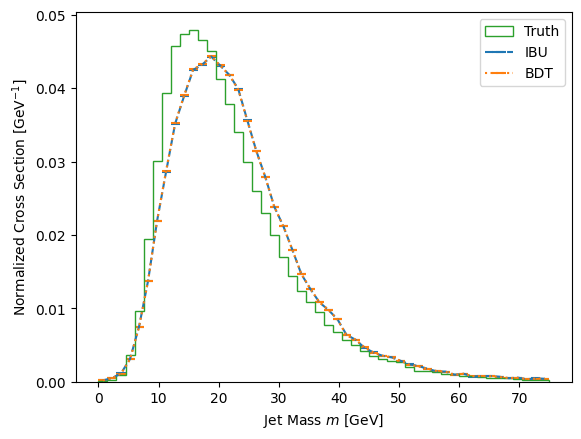

Unfolding Width
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3


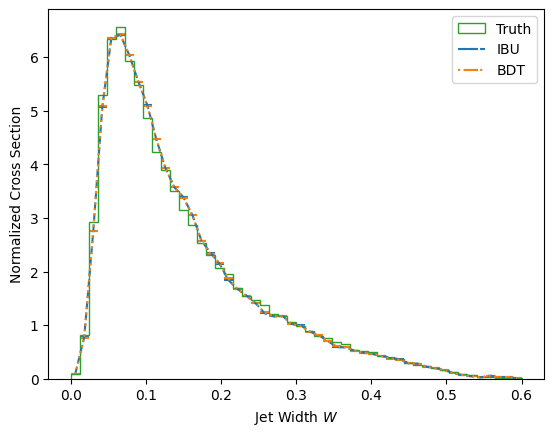

Unfolding Multiplicity
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3


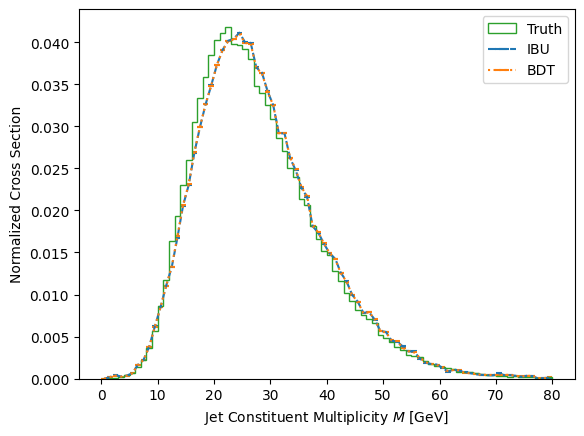

Unfolding SDMass
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3


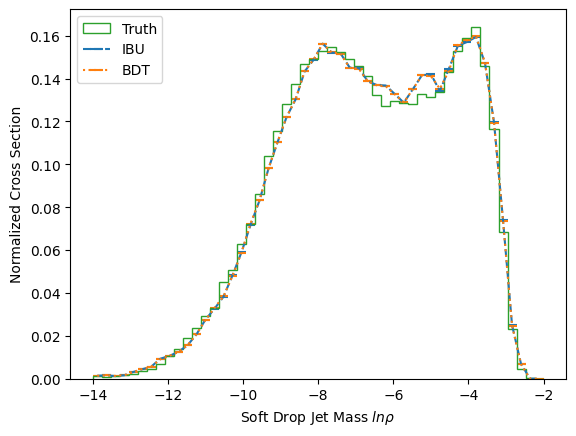

Unfolding zg
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3


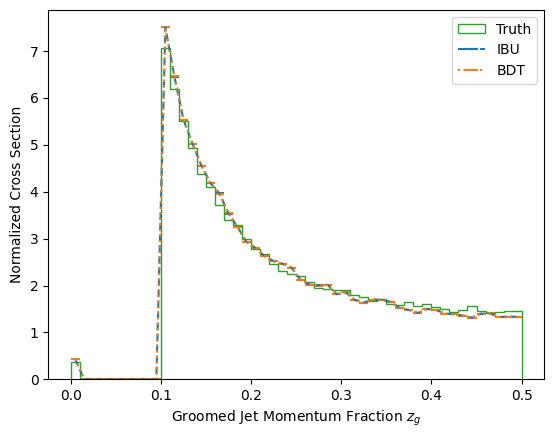

Unfolding Tau21
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3


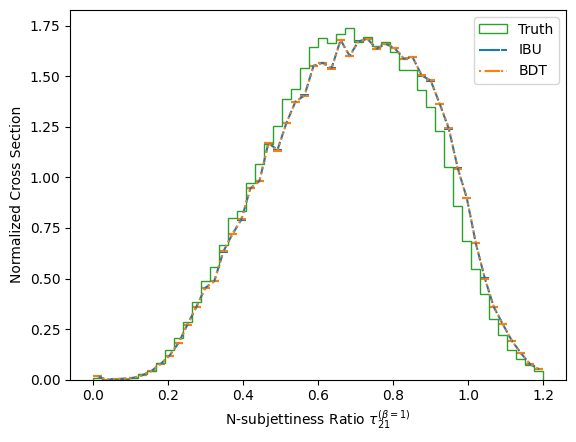

Using response matrix priors
Priors:

Vector (50)  is as follows

     |        1  |
------------------
   0 |9.0231e-05 
   1 |0.00030077 
   2 |0.00145372 
   3 |0.00559432 
   4 |0.0149282 
   5 |0.0302675 
   6 |0.0490556 
   7 |0.0646254 
   8 |0.075794 
   9 |0.0798745 
  10 |0.0815588 
  11 |0.0768066 
  12 |0.0717336 
  13 |0.0647658 
  14 |0.0575974 
  15 |0.0509504 
  16 |0.0426993 
  17 |0.0356613 
  18 |0.0304981 
  19 |0.0252547 
  20 |0.0218459 
  21 |0.0182467 
  22 |0.014838 
  23 |0.0127627 
  24 |0.0107876 
  25 |0.00977502 
  26 |0.00841153 
  27 |0.00623596 
  28 |0.00567453 
  29 |0.00464188 
  30 |0.00388996 
  31 |0.00340873 
  32 |0.00308791 
  33 |0.00262672 
  34 |0.00205526 
  35 |0.00185475 
  36 |0.00155398 
  37 |0.00130334 
  38 |0.00120308 
  39 |0.000852182 
  40 |0.000982515 
  41 |0.000751925 
  42 |0.000731874 
  43 |0.00067172 
  44 |0.000561437 
  45 |0.000491258 
  46 |0.000330847 
  47 |0.000340873 
  48 |0.000280719 
  49 |0.000290744 

Now unfo

Warning in <TROOT::Append>: Replacing existing TH1: unfolded_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: unfolded_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: unfolded_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: unfolded_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: unfolded_hist (Potential memory leak).


In [7]:
num_iterations = 4
for observable in observable_names:
    response = observable_responses[observable]
    print(f"Unfolding {observable}")
    unfolded_hist = binned_omnifold(
        response.Hresponse(),
        observable_pseudodata_hists[observable],
        num_iterations
    )
    efficiency = response.Vefficiency()
    for i in range(unfolded_hist.GetNbinsX()):
        corrected_content = efficiency[i]
        if efficiency[i] > 0:
            unfolded_hist.SetBinContent(i+1, unfolded_hist.GetBinContent(i+1)/efficiency[i])
        else:
            unfolded_hist.SetBinContent(i+1, unfolded_hist.GetBinContent(i+1))

    IBU_RooUnfold = ROOT.RooUnfoldBayes(response, observable_pseudodata_hists[observable], num_iterations)
    IBU_unfolded_hist = IBU_RooUnfold.Hunfold();

    unfolded_hist_array, bin_centers, bin_widths = TH1_to_numpy(unfolded_hist)
    normalized_unfolded_hist_array = unfolded_hist_array / (bin_widths * sum(unfolded_hist_array))
    
    IBU_hist_array, IBU_bin_centers, IBU_bin_widths = TH1_to_numpy(IBU_unfolded_hist)
    normalized_IBU_array = IBU_hist_array / (IBU_bin_widths * sum(IBU_hist_array))

    plt.figure()
    plt.errorbar(IBU_bin_centers, normalized_IBU_array, xerr = IBU_bin_widths/2, label="IBU", linestyle='dashed')
    plt.errorbar(bin_centers, normalized_unfolded_hist_array, xerr = bin_widths/2, label="BDT", linestyle='dotted')
    plt.hist(
        herwig_gen_dict[observable],
        bins = observable_binning[observable][0],
        range = (observable_binning[observable][1], observable_binning[observable][2]),
        label="Truth",
        density=True,
        histtype='step'
    )
    plt.legend()
    plt.ylabel("Normalized entries")
    plt.xlabel(observable_labels[observable])
    plt.ylabel("Normalized Cross Section $[\mathrm{GeV}^{-1}]$" if observable=="Mass" else "Normalized Cross Section")
    plt.show()